In [1]:
import qiskit
import numpy as np

import json, glob, math

In [2]:
glob.glob("*")

['elephant QFT-Copy1.ipynb',
 'elephant QFT.ipynb',
 'main.py',
 'plot-tools.py',
 'PlotTools.py',
 'png-tools.py',
 'QHOMER_IQFT.ipynb',
 'QHOMER_Optimizer_Function_FIXED.ipynb',
 'README.md',
 'Resources',
 'VectorQraphics.py']

In [3]:
def qubits_necessary(n):
    """log2 of n"""
    l2 = math.log2(n)
    assert l2 % 1 == 0, "not an integer power of 2"
    return int(l2)

def normalized(arr):
    """l2-normalization"""
    return arr / np.linalg.norm(arr, 2)

## Data Loading

In [32]:
with open("./Resources/elephant.5.json") as f:
    data = json.load(f)[:-1]
    data = normalized(np.array([complex(a, b) for a, b in data]))
    data = np.round(data, 2)

In [33]:
data

array([-0.17-0.11j, -0.17-0.08j, -0.21-0.12j, -0.23-0.11j, -0.18+0.01j,
       -0.21-0.04j, -0.22-0.06j, -0.21+0.02j, -0.19+0.11j,  0.01+0.17j,
        0.03+0.08j,  0.11+0.07j,  0.13+0.11j,  0.14+0.1j ,  0.13+0.1j ,
        0.07+0.16j,  0.13+0.18j,  0.19+0.09j,  0.2 -0.03j,  0.18-0.08j,
        0.16+0.02j,  0.23+0.07j,  0.11+0.07j,  0.1 -0.06j,  0.1 -0.12j,
        0.06-0.04j,  0.02-0.03j, -0.  -0.13j, -0.04-0.13j, -0.03-0.02j,
       -0.12-0.04j, -0.13-0.13j])

## Classical FT

In [34]:
data_ft = normalized(np.fft.fft(data))

In [35]:
data_ft

array([-0.00177042+0.00531127j, -0.34741276+0.00256972j,
       -0.05313864+0.07146191j,  0.06575981-0.00204549j,
       -0.12559591-0.00591879j,  0.04332638-0.0482607j ,
       -0.04624095+0.04511724j, -0.04705194-0.04991865j,
        0.09029165-0.04071977j,  0.08796132+0.01735637j,
        0.01115804+0.0196035j ,  0.02368619-0.01927542j,
        0.0022    -0.02394838j, -0.04680087+0.04093147j,
        0.00123625+0.0146417j ,  0.00472047+0.00483276j,
       -0.04071977+0.00885212j, -0.00922375-0.00399812j,
        0.04097572+0.0033255j , -0.02728684-0.04183952j,
       -0.00541551-0.02594886j, -0.00073366+0.02992501j,
       -0.03137557+0.02688424j, -0.06368088-0.02648499j,
       -0.09029165+0.07612826j,  0.07889283-0.05598811j,
        0.07182187+0.04016135j, -0.06693292-0.13726236j,
       -0.01282255+0.09122451j,  0.09484674+0.01746436j,
        0.07638026-0.10788828j, -0.63987391-0.54948334j])

## State Loading

In [36]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

In [37]:
def to_statevector(self):
    job = execute(self, Aer.get_backend("statevector_simulator"))
    return job.result().get_statevector()

QuantumCircuit.to_statevector = to_statevector

In [38]:
def QHomer_Init(data_ft):
    """creates an initialization circuit creating a state with data_ft as coefficients"""
    # number of qubits necessary
    qubit_count = qubits_necessary(len(data_ft))
    #print(f"need {qubit_count} qubits")

    # quantum and classical registers
    qregs = QuantumRegister(qubit_count)
    cregs = ClassicalRegister(qubit_count)

    # array of complex amplitudes
    desired_state = data_ft

    # initialization circut
    circuit = QuantumCircuit(qregs, cregs, name="data_loader_trivial")
    circuit.initialize(desired_state, range(qubit_count))
    
    return circuit

## Inverse QFT

In [39]:
def QHomer_IQFT(circuit):
    from qiskit.aqua.components.iqfts.standard import Standard as StandardIQFT

    IQFT = StandardIQFT(len(circuit.qubits))
    iqft = IQFT.construct_circuit(mode="circuit", qubits=circuit.qubits, circuit=circuit)

    return iqft


## Simulate and Measure

In [40]:
from qiskit.circuit import Measure

In [41]:
def QHomer_Measurement(circuit, idx, phase):
    """Measure given register with respect to basis |0> + exp(i phase)|1>"""
    
    qregs, cregs = circuit.qregs, circuit.cregs
    
    circuit.u1(phase, idx)
    circuit.h(idx)
    circuit.measure(idx, idx)
    
    return circuit

In [42]:
def QHomer_Cheap_Mans_Tomography(data_ft):
    simulator = Aer.get_backend("qasm_simulator")
    
    def _Cheap_Mans_Tomography(phase):
        circuit_init = QHomer_Init(data_ft)
        circuit_iqft = QHomer_IQFT(circuit_init)
        
        circuit_all = QHomer_Measurement(circuit_iqft, range(len(circuit_init.qubits)), -phase)    
        
        result = execute(circuit_iqft, backend = simulator, shots = 1000).result()
        
        return result.get_counts()
    
    def _pivot_measurement_counts(counts):
        n_qubits = len(list(counts.keys())[0])
        pivoted_counts = np.zeros(n_qubits)
        
        for i in range(n_qubits):
            for key in counts:
                if key[i] == "0":
                    pivoted_counts[i] += counts[key]
                    
        return pivoted_counts
    
    phase_results = {
        phase: _pivot_measurement_counts(
            _Cheap_Mans_Tomography(phase)
        ) for phase in np.arange(0, 2*math.pi, .1)
    }
    
    phases = np.array(list(phase_results.keys()))
    values = np.stack(list(phase_results.values()))
    
    best_phase_indices = np.argmax(values, axis=0)
    return phases[best_phase_indices]


phase_tomography_results = QHomer_Cheap_Mans_Tomography(data_ft)

In [43]:
print(phase_tomography_results)

[3.3 2.  0.5 0.2 0.2]


## Recreate Original

In [44]:
import functools

In [45]:
product_states = np.array([ [1, np.exp(complex(0, phase))] for phase in phase_tomography_results ])
expanded = functools.reduce(np.kron, product_states, [1])
xs, ys = np.array([ [np.real(p), np.imag(p)] for p in expanded ]).transpose()

In [46]:
xs, ys

(array([ 1.        ,  0.98006658,  0.98006658,  0.92106099,  0.87758256,
         0.76484219,  0.76484219,  0.62160997, -0.41614684, -0.58850112,
        -0.58850112, -0.73739372, -0.80114362, -0.90407214, -0.90407214,
        -0.97095817, -0.98747977, -0.93645669, -0.93645669, -0.84810003,
        -0.79096771, -0.65364362, -0.65364362, -0.49026082,  0.55437434,
         0.70866977,  0.70866977,  0.83471278,  0.88551952,  0.96017029,
         0.96017029,  0.9965421 ]),
 array([ 0.        ,  0.19866933,  0.19866933,  0.38941834,  0.47942554,
         0.64421769,  0.64421769,  0.78332691,  0.90929743,  0.8084964 ,
         0.8084964 ,  0.67546318,  0.59847214,  0.42737988,  0.42737988,
         0.23924933, -0.15774569, -0.35078323, -0.35078323, -0.52983614,
        -0.61185789, -0.7568025 , -0.7568025 , -0.87157577, -0.83226744,
        -0.70554033, -0.70554033, -0.55068554, -0.46460218, -0.2794155 ,
        -0.2794155 , -0.0830894 ]))

In [47]:
from PlotTools import plot

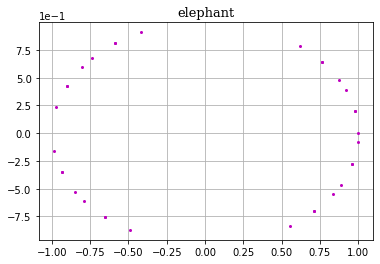

In [48]:
plot("elephant", xs, ys)